In [1]:
!rm -rf /kaggle/working/
!git clone https://github.com/svenspa/FML.git

rm: cannot remove '/kaggle/working/': Device or resource busy
Cloning into 'FML'...
remote: Enumerating objects: 479, done.
remote: Counting objects: 100% (479/479), done.
remote: Compressing objects: 100% (334/334), done.
remote: Total 479 (delta 225), reused 369 (delta 133), pack-reused 0
Receiving objects: 100% (479/479), 1.31 MiB | 3.61 MiB/s, done.
Resolving deltas: 100% (225/225), done.


In [2]:
import os
origin_path = "/kaggle/working"
fml_path = "/kaggle/working/FML"

In [3]:
!pip install arch
!pip install yfinance
!pip install fastparquet

     |████████████████████████████████| 902 kB 513 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=07110a420a62d8bb48dd83d3e57d4e6e2f4d950057c6940f108b6943579e81d7
  Stored in directory: /root/.cache/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking
     |████████████████████████████████| 1.2 MB 517 kB/s            
     |████████████████████████████████| 59 kB 4.8 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 1.6 MB 35.3 MB/s            
  Created wheel for thrift: filename=thrift-0.15.0-cp37-cp37m-linux_x86_64.whl size=413806 sha256=d3051eef4287cae6126fee057836cbcb5dc7d7cd628e88626715172fb56c06e2
  Stored in directory: /root/.cache/pip/wheels/ba/1f/8e/e6fd36837eecf3d1f2b23f1729477e8e06558d8d60b7093f51
Successfully built thrift


In [4]:
os.chdir(fml_path)

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import yfinance as yf

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

from data import DataGJR, DataRes
from market_dynamics import bs_call_price
from models import ControlNet, EnsembleNet
from train import train_val
from risk_measures import median_loss
from utils import call_payoff, stochastic_integral


In [6]:
GJR_FOLDER = "../input/gjr-vol/v2_2/v2/"
RES_FOLDER = "../input/gjr-vol/ressim/resssim/"

In [7]:
os.chdir(origin_path)

## Data

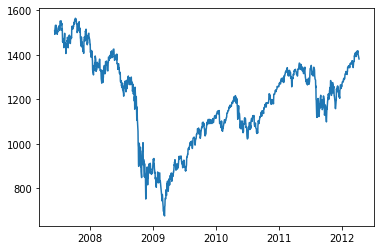

In [8]:
ticker = yf.Ticker('^GSPC')
hist = ticker.history(start='2007-06-11', end='2012-04-10').Close
plt.plot(hist);

In [9]:
# From fitting the GARCH model using R get following parameters

SIGMA = 0.1221684
MU = 0.056105

SQRT_252 = 252 ** 0.5

In [10]:
h_params = {"N_SIM": 4000,
            "RF": 0,
            "N_DIMS": 2,
            "FC_DIM": 20,
            "LR": 0.005,
            "GAMMA": 0.96,
            "EPOCHS": 10,
            "BATCH_SIZE": 256,}

In [11]:
initial_value = hist.iloc[0]
strike = initial_value
n_steps = 30
price = bs_call_price(n_steps, initial_value, SIGMA, h_params["RF"], strike)
initial_value, strike, SIGMA, price

(1509.1199951171875, 1509.1199951171875, 0.1221684, 21.0855397479188)

In [12]:
dt = DataGJR(GJR_FOLDER, price, call_payoff, {"strike": strike}, splits=h_params["N_SIM"], S0=initial_value, sigma_0=SIGMA, mu_const=MU, take_log=True, vol_feature=False)
res_dt = DataRes(RES_FOLDER, price, call_payoff, {"strike": strike}, splits=100, S0=initial_value, take_log=True)

## Training

In [13]:
%%time

# Training three models on different training paths

n_models = 3
models, optimizers, schedulers = [], [], []
n = 900
val_n = 20
criterion = torch.nn.MSELoss()

for _ in range(n_models):
    model = ControlNet(n_steps, 1, [20, 20], 1, learn_price=False, learn_vol=False)
    models.append(model)
    optimizer = Adam(model.parameters(), lr=h_params["LR"])
    optimizers.append(optimizer)
    schedulers.append(ExponentialLR(optimizer, gamma=h_params["GAMMA"]))

idx_list = np.array_split(np.arange(n) + 1, 3)
val_idx_list = [np.arange(start=idx[-1]+1, stop=idx[-1]+1+val_n) for idx in idx_list]

# Training each model

res_list = []
for model, optimizer, scheduler, indices, val_indices in zip(models, optimizers, schedulers, idx_list, val_idx_list):
    results = train_val(res_dt, model, criterion, optimizer, h_params["EPOCHS"], indices, val_indices, scheduler, metric=median_loss, val_every=5)
    res_list.append(results)

ens = EnsembleNet(models)

Epoch 0: 100%|██████████| 300/300 [00:21<00:00, 14.27batch/s, loss=92.3, metric=50.2]


validation loss: 67566.8005859375


Epoch 5: 100%|██████████| 300/300 [00:17<00:00, 16.81batch/s, loss=84.6, metric=49]


validation loss: 6534.01025390625


Epoch 0: 100%|██████████| 300/300 [00:20<00:00, 14.68batch/s, loss=93.2, metric=60.9]


validation loss: 43368.84375


Epoch 5: 100%|██████████| 300/300 [00:18<00:00, 16.46batch/s, loss=83.6, metric=49.1]


validation loss: 10035.874609375


Epoch 0: 100%|██████████| 300/300 [00:20<00:00, 14.93batch/s, loss=93.8, metric=54.5]


validation loss: 49106.8009765625


Epoch 5: 100%|██████████| 300/300 [00:18<00:00, 16.13batch/s, loss=76, metric=44.2]


validation loss: 22911.30576171875


Epoch 9: 100%|██████████| 300/300 [00:18<00:00, 16.14batch/s, loss=73.5, metric=46]

CPU times: user 14min 52s, sys: 18.8 s, total: 15min 11s
Wall time: 9min 9s


## Out of sample validation

In [14]:
diffs = []

for i in np.arange(n+10,1000):
    x, x_inc, payoff, price = res_dt[i]
    output = ens(x)
    si = stochastic_integral(x_inc, output)
    diff = (price.squeeze() + si).float() - payoff.float()
    diffs.append(diff)
    
d = torch.cat(diffs)

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 8.993037223815918
Using median 7.257210731506348
Using mode 0.07483673095703125


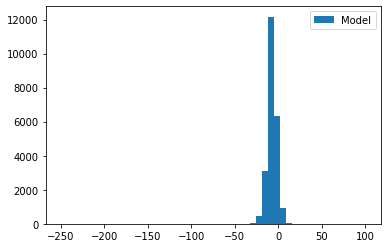

In [15]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

## Validation on real data (Same time period)

In [16]:
# Creating the validation paths
n_steps = 30

n_steps = 30
step = 5  # number of days by which to shift the window
sigma_est_period = 30
valid_paths, valid_prices, valid_strikes, sigma_estimates = [], [], [], []

for i in np.arange(start=sigma_est_period, stop=len(hist) - n_steps, step=step):
    
    valid_path = hist[i:i+n_steps+1]
    simga_est_path = hist[i-sigma_est_period:i]
    sigma_est = simga_est_path.diff().dropna().std() / 100
    sigma_estimates.append(sigma_est)

    S0 = valid_path[0]
    valid_price = bs_call_price(n_steps, S0, sigma=sigma_est, rf=0, strike=S0)      

    valid_paths.append(valid_path)
    valid_strikes.append(S0)
    valid_prices.append(valid_price)

valid_paths = np.array(valid_paths)
valid_paths = valid_paths.reshape(valid_paths.shape[0], valid_paths.shape[1], 1)
valid_paths = torch.from_numpy(valid_paths).float()

valid_prices = torch.Tensor(valid_prices)
valid_strikes = torch.Tensor(valid_strikes)

In [17]:
if dt.take_log:
    paths = valid_paths.squeeze().T /  valid_paths[:, 0].squeeze()
    paths = paths.T
    paths = torch.unsqueeze(paths, dim=2)
    paths = torch.log(paths[:, :-1])
    x_inc = valid_paths.squeeze().diff()
    payoff = call_payoff(valid_paths.squeeze(), strike=valid_strikes)
    
    
output = ens(paths)
si = stochastic_integral(x_inc, output)
diff = (valid_prices.squeeze() + si).float() - payoff.float()
d = diff

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 20.301376342773438
Using median 12.281146049499512
Using mode 0.003604888916015625


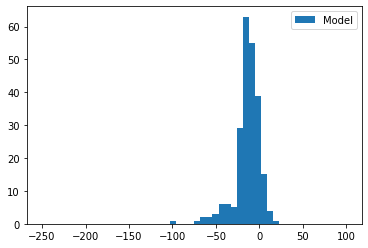

In [18]:
plt.hist(d.detach().numpy(), range=(-250, 100), bins=50, label=['Model'])
plt.legend();

## Validation on real data (Future time period)

In [19]:
hist_oos = ticker.history(start='2012-04-10', end='2014-04-10').Close

# Creating the validation paths
n_steps = 30

n_steps = 30
step = 5  # number of days by which to shift the window
sigma_est_period = 30
valid_paths, valid_prices, valid_strikes, sigma_estimates = [], [], [], []

for i in np.arange(start=sigma_est_period, stop=len(hist_oos) - n_steps, step=step):
    
    valid_path = hist_oos[i:i+n_steps+1]
    simga_est_path = hist_oos[i-sigma_est_period:i]
    sigma_est = simga_est_path.diff().dropna().std() / 100
    sigma_estimates.append(sigma_est)

    S0 = valid_path[0]
    valid_price = bs_call_price(n_steps, S0, sigma=sigma_est, rf=0, strike=S0)      

    valid_paths.append(valid_path)
    valid_strikes.append(S0)
    valid_prices.append(valid_price)

valid_paths = np.array(valid_paths)
valid_paths = valid_paths.reshape(valid_paths.shape[0], valid_paths.shape[1], 1)
valid_paths = torch.from_numpy(valid_paths).float()

valid_prices = torch.Tensor(valid_prices)
valid_strikes = torch.Tensor(valid_strikes)

In [20]:
if dt.take_log:
    paths = valid_paths.squeeze().T /  valid_paths[:, 0].squeeze()
    paths = paths.T
    paths = torch.unsqueeze(paths, dim=2)
    paths = torch.log(paths[:, :-1])
    x_inc = valid_paths.squeeze().diff()
    payoff = call_payoff(valid_paths.squeeze(), strike=valid_strikes)
    
    
output = ens(paths)
si = stochastic_integral(x_inc, output)
diff = (valid_prices.squeeze() + si).float() - payoff.float()
d = diff

print('Model:')
print(f"RMSE {(d ** 2).mean() ** 0.5}")
print(f"Using median {(d ** 2).median() ** 0.5}")
print(f"Using mode {(d ** 2).mode()[0] ** 0.5}")

Model:
RMSE 18.253767013549805
Using median 13.790689468383789
Using mode 0.9316787719726562
